# Install Dependencies

In [26]:
!pip install torch==1.9.0 torchtext==0.10.0

# Import Necessary Libraries

In [27]:
import torch
import torch.nn as nn

import random
import argparse

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from torchtext.legacy import data
from torchtext.legacy import datasets

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import time
from datetime import datetime

# Use GPU
Set Device = CUDA if available

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Hyper-Parameters

In [29]:
argument_parser = argparse.ArgumentParser()
argument_parser.add_argument("--epochs", dest = "EPOCHS", type = int, default = 5)
argument_parser.add_argument("--batch_size", dest = "BATCH_SIZE", type = int, default = 64)
argument_parser.add_argument("--embed_dim", dest = "EMBED_DIM", type = int, default = 100)
argument_parser.add_argument("--hidden_dim", dest = "HIDDEN_DIM", type = int, default = 256)
argument_parser.add_argument("--num_layers", dest = "NUM_LAYERS", type = int, default = 2)
argument_parser.add_argument("--bidirectional", dest = "BIDIRECTIONAL", type = bool, default = True)
argument_parser.add_argument("--optimizer", dest = "OPTIMIZER", type = str, default = 'Adam')
argument_parser.add_argument("--loss_fn", dest = "LOSS_FN", type = str, default = 'BCELoss')
argument_parser.add_argument("--learning_rate", dest = "LEARNING_RATE", type = float, default =  1e-2)
argument_parser.add_argument("--dropout", dest = "DROPOUT", type = float, default =  0.2)
arguments, unknown = argument_parser.parse_known_args()

# Set SEED value for reproducible results
# and
# Load Dataset

In [30]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = torch.float)

# Create Dataset Splits and Build Vocab

In [31]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [32]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [33]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")
print(f"Most common 20 tokens in TEXT vocabulary: {TEXT.vocab.freqs.most_common(20)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2
Most common 20 tokens in TEXT vocabulary: [('the', 203592), (',', 193330), ('.', 166323), ('a', 109962), ('and', 109787), ('of', 101268), ('to', 94119), ('is', 76722), ('in', 61228), ('I', 54178), ('it', 53755), ('that', 49541), ('"', 44374), ("'s", 43358), ('this', 42543), ('-', 37707), ('/><br', 35637), ('was', 35043), ('as', 30469), ('with', 29978)]


# Dictionary for words (Vocabulary)


In [34]:
word2idx = TEXT.vocab.stoi

idx2word = { idx: word for word, idx in word2idx.items() }

unk_token = word2idx['<unk>']
padding_token = word2idx['<pad>']
print(f'UNK Token: {unk_token}')
print(f'PAD Token: {padding_token}')

UNK Token: 0
PAD Token: 1


# Add Input Dim and Output Dim to arguments

In [35]:
argument_parser.add_argument("--input_dim", dest = "INPUT_DIM", type = int, default = len(word2idx))
argument_parser.add_argument("--output_dim", dest = "OUTPUT_DIM", type = int, default = 1)
arguments, unknown = argument_parser.parse_known_args()
print(arguments)

Namespace(BATCH_SIZE=64, BIDIRECTIONAL=True, DROPOUT=0.2, EMBED_DIM=100, EPOCHS=5, HIDDEN_DIM=256, INPUT_DIM=25002, LEARNING_RATE=0.01, LOSS_FN='BCELoss', NUM_LAYERS=2, OPTIMIZER='Adam', OUTPUT_DIM=1)


# IMDB Dataset Class

In [36]:
class IMDBDataset(Dataset):

  def __init__(self, 
               data):
      self.data = data.examples

  def __len__(self):
      return len(self.data)

  def __getitem__(self, 
                  idx: int):
      """
      Returns
      -------
      tuple
            a tuple of encoded text and encoded label from the 
            dataset (an instance from a dataset given by idx)
      """
      # Encoding Text
      encoded_text = self.encode_text(self.data[idx].text)
      # Encoding Label
      encoded_label = self.encode_label(self.data[idx].label)
      return encoded_text, encoded_label

  def encode_text(self, 
                  text: list):
      text_vector = list()
      for word in text:
          if word in word2idx:
              text_vector.append(word2idx[word])
          else:
              text_vector.append(1)
      return text_vector

  def encode_label(self, 
                   label: int):
      label = 0 if label == 'pos' else 1
      return label

# Datset Object for DataLoader

In [37]:
train_ds = IMDBDataset(train_data)

val_ds = IMDBDataset(valid_data)

test_ds = IMDBDataset(test_data)

# Custom Collate function

In [38]:
def custom_collate_fn(batch):
    """
    Adds padding token '0' at the end of each text vector to make it
    of the same length as the maximum length input in the batch.

    Returns
    -------
    tuple
        a tuple of padded text tensors, label tensors and text lengths tensor in a batch
    """
    texts, labels = zip(*batch)
    
    texts_tensor = [torch.tensor(text, device = device) for text in texts]
    labels_tensor = torch.tensor(labels, device = device)

    lengths = [len(text) for text in texts]
    lengths = torch.tensor(lengths, device = 'cpu') # Lengths need to be on CPU
    
    texts_padded = pad_sequence(texts_tensor, batch_first = False, padding_value = padding_token)
    
    return texts_padded, labels_tensor, lengths

# PyTorch Data Loaders

In [39]:
train_loader = DataLoader(train_ds, 
                          batch_size = arguments.BATCH_SIZE, 
                          shuffle = True, 
                          collate_fn = custom_collate_fn)

val_loader = DataLoader(val_ds, 
                        batch_size = arguments.BATCH_SIZE, 
                        shuffle = True, 
                        collate_fn = custom_collate_fn)

test_loader = DataLoader(test_ds, 
                         batch_size = arguments.BATCH_SIZE, 
                         shuffle = False, 
                         collate_fn = custom_collate_fn)

# LSTM Model

In [40]:
class LSTM(nn.Module):

    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout):
        super(LSTM, self).__init__()
        # Initialize Embedding Layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        # Initialzie LSTM layer to process the vector sequences 
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = False)
        num_directions = 2 if bidirectional else 1
        # Initialize Dense layer to predict
        self.fc = nn.Linear(hidden_dim * num_directions, output_dim)
        # Initialize dropout to improve with regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, 
                x, 
                x_lengths):
        # Embedding Layer
        embedded = self.embedding(x)
        # Dropout Layer before LSTM Layer
        embedded = self.dropout(embedded)
        # Packed Sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                                                            x_lengths, 
                                                            batch_first = False, 
                                                            enforce_sorted = False)
        # LSTM Layer
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # Unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, 
                                                                  batch_first = False)
        # Concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers and Apply Dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        # Fully Connected Layer
        output = self.fc(hidden)
        return output

In [41]:
model = LSTM(arguments.INPUT_DIM, 
             arguments.EMBED_DIM, 
             arguments.HIDDEN_DIM, 
             arguments.OUTPUT_DIM, 
             arguments.NUM_LAYERS, 
             arguments.BIDIRECTIONAL, 
             arguments.DROPOUT).to(device)

print('LSTM Model: ', model)

LSTM Model:  LSTM(
  (embedding): Embedding(25002, 100)
  (lstm): LSTM(100, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


# Total Trainable parameters for LSTM Model

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


# Train and Validation Functions for the Model

In [43]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

# Model Train Function
def train(loader, 
          model, 
          optimizer, 
          loss_fn):
    model.train()
    losses = []
    pbar = tqdm(loader, desc = 'Training...', colour = 'red')
    for x, y, x_lengths in pbar:
        optimizer.zero_grad()
        
        # Calculate y_pred
        y_pred = model(x, x_lengths).squeeze(1)
        
        loss = loss_fn(y_pred, y.float())
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())

        acc = binary_accuracy(y_pred, y)
        
        # Calculate gradients for w/b
        loss.backward()  
        # Update weights according to optimizer rules
        optimizer.step()          
    return sum(losses) / len(losses), acc

# Model Evaluate Function
def evaluate(loader, 
             model, 
             loss_fn):
    model.eval()
    losses = []
    pbar = tqdm(loader, desc = 'Evaluation...', colour = 'green')
    for x, y, x_lengths in pbar:

        # Calculate y_pred
        y_pred = model(x, x_lengths).squeeze(1)
        
        loss = loss_fn(y_pred, y.float())
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())

        acc = binary_accuracy(y_pred, y)
              
    return sum(losses) / len(losses), acc

In [44]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Model Training and Validation

In [45]:
# Optimizer
if arguments.OPTIMIZER == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr = arguments.LEARNING_RATE)

# Loss Function
if arguments.LOSS_FN == 'BCELoss':
    loss_fn = nn.BCEWithLogitsLoss().to(device)

# Initialize Best Validation Loss
best_valid_loss = float('inf')
    
# Path to Save Best Model
PATH = f'lstm-best-model.pt'

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

batch_start_time = time.time()

for epoch in range(arguments.EPOCHS):

    start_time = time.time()
    
    # Avg Train Loss, Train Accuracy
    train_loss, train_acc = train(train_loader, 
                                  model, 
                                  optimizer, 
                                  loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc.detach().cpu().numpy())

    # Avg Val Loss, Val Accuracy
    val_loss, val_acc = evaluate(val_loader, 
                                 model, 
                                 loss_fn)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc.detach().cpu().numpy())

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'\n\tEpoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValidation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%\n')

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), PATH)

batch_end_time = time.time()
batch_elapsed_time = batch_end_time - batch_start_time
print(f'Training Time for Batch Size: {arguments.BATCH_SIZE} -> {batch_elapsed_time:.2f}s')

Evaluation...: 100%|██████████| 118/118 [00:09<00:00, 12.17it/s, Loss=0.758]



	Epoch: 01 | Epoch Time: 1m 15s
	Train Loss: 0.691 | Train Acc: 60.71%
	Validation Loss: 0.671 | Validation Acc: 41.67%



Evaluation...: 100%|██████████| 118/118 [00:09<00:00, 12.08it/s, Loss=0.587]



	Epoch: 02 | Epoch Time: 1m 17s
	Train Loss: 0.599 | Train Acc: 71.43%
	Validation Loss: 0.576 | Validation Acc: 66.67%



Evaluation...: 100%|██████████| 118/118 [00:09<00:00, 12.00it/s, Loss=0.942]



	Epoch: 03 | Epoch Time: 1m 16s
	Train Loss: 0.417 | Train Acc: 85.71%
	Validation Loss: 0.406 | Validation Acc: 66.67%



Evaluation...: 100%|██████████| 118/118 [00:09<00:00, 11.96it/s, Loss=0.461]



	Epoch: 04 | Epoch Time: 1m 16s
	Train Loss: 0.305 | Train Acc: 92.86%
	Validation Loss: 0.382 | Validation Acc: 83.33%



Evaluation...: 100%|██████████| 118/118 [00:09<00:00, 12.12it/s, Loss=0.327]


	Epoch: 05 | Epoch Time: 1m 18s
	Train Loss: 0.250 | Train Acc: 92.86%
	Validation Loss: 0.356 | Validation Acc: 91.67%

Training Time for Batch Size: 64 -> 384.10s


# Line Plot Comparison: 
1. Training vs Val Loss
2. Training vs Val Accuracy



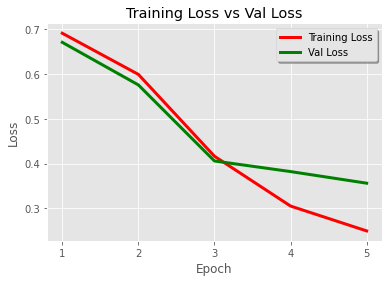

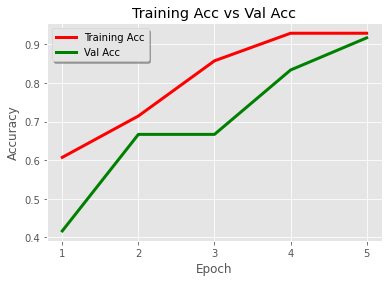

In [46]:
epochs = np.arange(arguments.EPOCHS) + 1

def plot_line(line_A_vals, 
              line_B_vals, 
              line_A_label, 
              line_B_label, 
              xlabel, 
              ylabel, 
              title):
    plt.style.use('ggplot')
    plt.plot(epochs, line_A_vals, label = line_A_label, color = "red", linewidth = '3')
    plt.plot(epochs, line_B_vals, label = line_B_label, color = "green", linewidth = '3')
    plt.xlabel(xlabel)
    plt.xticks(epochs)
    plt.ylabel(ylabel)
    plt.title(title, color = 'black')
    plt.legend(shadow = True)
    plt.show()
    
# Training vs Val Loss Plot
plot_line(train_loss_list, 
          val_loss_list, 
          'Training Loss', 
          'Val Loss', 
          'Epoch', 
          'Loss', 
          'Training Loss vs Val Loss')

# Training vs Val Acc Plot
plot_line(train_acc_list, 
          val_acc_list, 
          'Training Acc', 
          'Val Acc', 
          'Epoch', 
          'Accuracy', 
          'Training Acc vs Val Acc')

## Load the saved model

In [47]:
saved_model = LSTM(arguments.INPUT_DIM, 
                   arguments.EMBED_DIM, 
                   arguments.HIDDEN_DIM, 
                   arguments.OUTPUT_DIM, 
                   arguments.NUM_LAYERS, 
                   arguments.BIDIRECTIONAL, 
                   arguments.DROPOUT).to(device)

saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()

LSTM(
  (embedding): Embedding(25002, 100)
  (lstm): LSTM(100, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Test Loss and Accuracy

In [48]:
# Avg Test Loss, Test Accuracy
test_loss, test_acc = evaluate(test_loader, 
                               saved_model, 
                               loss_fn)
print(f'\n\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluation...: 100%|██████████| 391/391 [00:31<00:00, 12.28it/s, Loss=0.266]


	Test Loss: 0.382 | Test Acc: 95.00%


# Deliverable Plots

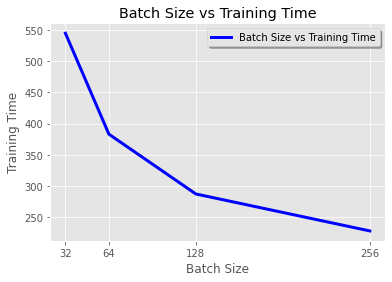

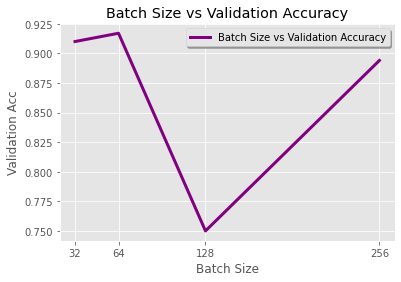

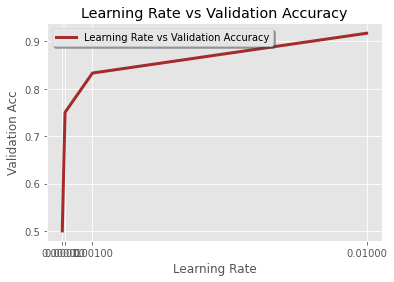

In [49]:
batch_size = [32, 64, 128, 256]
training_time = [545.12, 382.94, 286.81, 227.46]
val_set_acc = [0.91, 0.917, 0.75, 0.894]
learning_rate_vals = [0.01, 0.001, 0.0001, 0.00001]
val_set_acc_lr = [0.917, 0.833, 0.75, 0.50]

def plot_comp_line(x_vals, 
              y_vals,
              line_label,
              xlabel, 
              ylabel, 
              title, 
              line_color):
    plt.style.use('ggplot')
    plt.plot(x_vals, y_vals, label = line_label, color = line_color, linewidth = '3')
    plt.xlabel(xlabel)
    plt.xticks(x_vals)
    plt.ylabel(ylabel)
    plt.title(title, color = 'black')
    plt.legend(shadow = True)
    plt.show()

# Batch Size vs Training Time Plot
plot_comp_line(batch_size, 
               training_time, 
               'Batch Size vs Training Time',  
               'Batch Size', 
               'Training Time',
               'Batch Size vs Training Time', 
               'blue')

# Batch Size vs Val Acc Plot
plot_comp_line(batch_size, val_set_acc, 
               'Batch Size vs Validation Accuracy', 
               'Batch Size', 
               'Validation Acc',
               'Batch Size vs Validation Accuracy', 
               'purple')

# Learning Rate vs Val Acc Plot
plot_comp_line(learning_rate_vals, val_set_acc_lr, 
               'Learning Rate vs Validation Accuracy', 
               'Learning Rate', 
               'Validation Acc',
               'Learning Rate vs Validation Accuracy', 
               'brown')

# Test for Model Correctness

In [50]:
max_n_test_instances = 5
i = 1
for x, _, x_lengths in val_loader:
  score = saved_model(x, x_lengths).squeeze(1)
  print(score)
  if i >= max_n_test_instances:
    break
  else:
    i += 1

tensor([-1.6132,  3.7481,  4.8990,  1.9808, -0.4259, -0.5633,  5.6465,  3.8416,
         5.3649, -2.0478, -4.3970,  3.6095, -5.2872,  4.3105,  9.1310, -4.0231,
        -0.6245,  1.6504, -2.4430, -0.5821, -4.0144, -0.0742,  7.2715,  2.5244,
         9.6311,  0.4599, -0.6269, -2.2615, -0.7906,  5.6397,  4.5671,  2.5422,
         5.2128,  0.9681,  3.0722,  5.2602, -0.5407, -2.4662,  0.0992,  0.2827,
         6.4206, -2.8500, -0.0829, -4.5294,  2.7996,  5.6678,  4.5088, -2.5029,
         1.6050, -2.8437, -2.9465,  1.3689,  0.4227, -2.4305,  5.9455,  4.7829,
         3.8018, -3.6828,  1.7359,  5.2415, -3.8147, -2.6945, -2.7062,  4.3414],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.1010,  5.2262, -2.5014,  1.0946,  1.5776,  5.6394,  1.5677, -4.3012,
        -1.0296, -1.5993, -2.6062,  6.7674, -2.2116,  3.0958,  5.9411, -4.9794,
        -1.1143,  5.2151,  0.0403,  4.1267, -4.9672, -2.2584,  5.7212,  0.7798,
        -5.3715,  1.1318,  7.7266,  3.0828, -1.6399, -3.9963,  1.36